In [1]:
import pandas as pd
import requests
import re
import random
from random import sample
import json
import math
from utils import *
from sentence_classifier import SentenceClassifier
from tokenizer_class import TokenizerClass
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
import csv
import keras
from keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras import callbacks, layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
import wandb

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jannis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
wandb.init(
    project='LSTM-sweep',
    config={
    'class_size':25000,
    'random_state':2,
    'compile_metric':'accuracy',
    'dense_activation':'relu',
    'ES_metric':'val_loss',
    'eval_share':0.3,
    'LSTM_dropout':0.1,
    'hidden_layer_size':256, #256
    'epochs':4,
    'huggingface_model':'distilbert-base-german-cased',
    'loss_function':None,
    'learning_rate':0.00032,
    }
)
config=wandb.config

wandb: Currently logged in as: ether-meter. Use `wandb login --relogin` to force relogin


In [ ]:
sweep_configuration = {
    'method': 'bayes',
    'name': 'sweep-first',
    'metric': {
        'goal': 'maximize', 
        'name': 'AUC'
		},
    'parameters': {
    'class_size':25000,
    'random_state':2,
    'compile_metric':['accuracy','binary_accuracy','f1-score','AUC'],
    'dense_activation':['relu','tanh','relu','softmax','elu','selu','softplus','softsign','swish'],
    'ES_metric':['loss','val_loss','accuracy','val_accuracy'],
    'eval_share':{max:0.5,min:0.1},
    'LSTM_dropout':{max:0.5,min:0.001},
    'hidden_layer_size':{max:512,min:16}, #256
    'epochs':{max:20,min:2},
    'loss_function':None,
    'learning_rate':{max:0.1,'min':0.00001},
    }
     }


In [4]:
def fetch_prep_wiki_dataset(path='fulltext_wiki_protected.csv'):
    all_articles=pd.read_csv(path,sep=',')[['title','bytes','full_text']]
    i=1
    df=preprocess_classify_wiki_text(all_articles['full_text'].iloc[0])
    while i<len(all_articles):
        working_df=preprocess_classify_wiki_text(all_articles['full_text'].iloc[i])
        df=pd.concat([df,working_df])
        i+=1
    return df

def evaluate_model(model,claim_extract):
    annotated=pd.read_csv('FullAnnotated1.csv',sep=';',dtype={'sentence':'str'})
    annotated=(annotated[annotated['to_exclude']==0])
    annotated_text=list(annotated['sentence'])
    annotated_padded = claim_extract.raw_text_to_padded_sequences(list(annotated_text))
    annotated['predictions']=list(model.predict(annotated_padded))
    plot,auc=plot_compute_AUC(annotated['is_claim'],annotated['predictions'])
    return plot,auc

def init_classes(df_train,eval_share):
    tokenizer=TokenizerClass()
    claim_extract=SentenceClassifier(tokenizer_class=tokenizer)
    claim_extract.preprocess_train_val(df_train,eval_share)
    return claim_extract


Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-02-15 22:27:01.096498: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-15 22:27:01.096604: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 32)            3049312   
                                                                 
 lstm (LSTM)                 (None, 256)               295936    
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 3,345,505
Trainable params: 3,345,505
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4


2023-02-15 22:27:01.370492: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-15 22:27:02.061462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-15 22:27:02.254805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-15 22:27:02.450119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


520/520 [==============================] - ETA: 0s - loss: 0.7190 - accuracy: 0.5267

2023-02-15 22:27:17.706183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-15 22:27:17.780195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


520/520 [==============================] - 18s 33ms/step - loss: 0.7190 - accuracy: 0.5267 - val_loss: 0.6720 - val_accuracy: 0.5794
Epoch 2/4
520/520 [==============================] - 15s 28ms/step - loss: 0.6627 - accuracy: 0.6368 - val_loss: 0.7075 - val_accuracy: 0.4140
Epoch 3/4
520/520 [==============================] - 14s 27ms/step - loss: 0.6472 - accuracy: 0.6659 - val_loss: 1.0083 - val_accuracy: 0.5725
Epoch 3: early stopping
1/4 [======>.......................] - ETA: 0s

2023-02-15 22:27:48.621855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-15 22:27:48.671979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 38ms/step


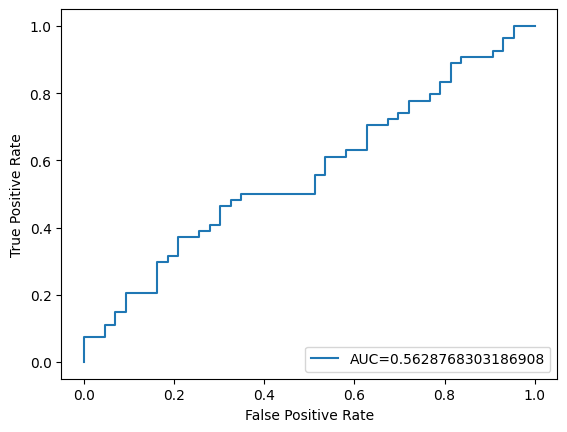

In [5]:
df = fetch_prep_wiki_dataset()
df_train=df.sample(50000,random_state=2)
claim_extract = init_classes(df_train,config.eval_share)
model = keras.models.Sequential()
model.add(layers.Embedding(claim_extract.tokenizer_class.num_unique_words, 32, input_length=32))
model.add(layers.LSTM(config.hidden_layer_size, dropout=config.LSTM_dropout))
model.add(layers.Dense(1, activation=config.dense_activation))
model.summary()
loss = keras.losses.BinaryCrossentropy(from_logits=False)
optim = keras.optimizers.Adam(learning_rate=config.learning_rate)
metrics = [config.compile_metric]

model.compile(loss=loss, optimizer=optim, metrics=metrics)
es = EarlyStopping(config.ES_metric, mode='min', verbose=1, patience=2)
model.fit(claim_extract.train_padded,
                       claim_extract.train_df['target'],
                       validation_data=(claim_extract.val_padded, claim_extract.val_df['target']),
                       callbacks=[es],
                       epochs=config.epochs)
plot,auc = evaluate_model(model,claim_extract)
wandb.log({'AUC':auc,'whole_size':len(claim_extract.whole_df),'train_size':len(claim_extract.train_df)})


4/4 [==============================] - 0s 19ms/step


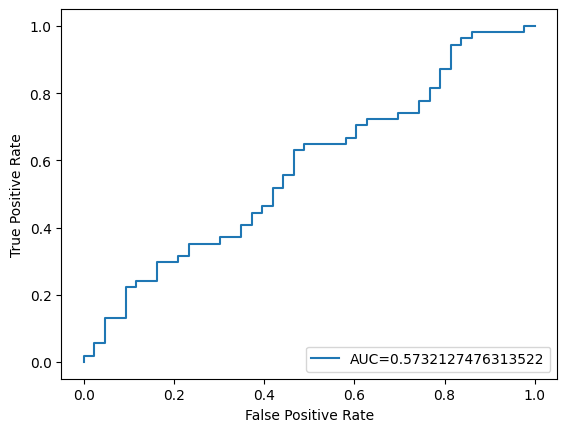